# `PyTorch` for Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/notebooks/Lab-11.Pytorch_NN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE**: This notebook is the same as the *non-solved* version.


In the following Lab, we will learn how to define, train and evaluate a *Neural Network* model in PyTorch. We will use a simple *Convolutional Neural Network* as an example, and we will train it on the *MNIST* dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn # basic building blocks for graphs, layers etc..
import torch.nn.functional as F # dropout, loss, activation functions, and more
# visto che lavoreremo con immagini:
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

## Intro to PyTorch

`PyTorch` is a Python/C++-based *Deep Learning* and *scientific computing* package that mainly provides two high-level features:  
* **Tensor computation** (like `NumPy`) with strong GPU acceleration 
* **Deep neural networks** built on an **autograd** system ([more info](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html))

The flexibility of `PyTorch` and its *Pythonic* interfaces make it the most widely adopted framework for research and development, both in academia and industry.

For more info, you can have a look at the [official documentation](https://pytorch.org/docs/stable/index.html) or refer to [this book](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf).

Fun fact: *PyTorch was first created by Meta AI in 2016, and is now the base for Tesla's autopilot!* 

Like NumPy, PyTorch provides its own multidimensional array class, called `Tensor`. `Tensor`s are essentially the equivalent of NumPy `ndarray`s.
* `Tensor` draws a lot of methods from NumPy
* `Tensor` has CUDA support (faster!)

L'unica differenza è che i Tensori offorno supporto per CUDA per la parallelizzazione

In [2]:
# create custom Tensor and ndarray
x = torch.Tensor([[1,5,4],[3,2,1]]) # x è un tensore
y = np.array([[1,5,4],[3,2,1]]) # y è un np.array

def pretty_print(obj, title=None):
    if title is not None:
        print(title)
    print(obj)
    print("\n")

pretty_print(x, "x")
pretty_print(y, "y")

x
tensor([[1., 5., 4.],
        [3., 2., 1.]])


y
[[1 5 4]
 [3 2 1]]




What are these types of objects?

In [3]:
print(x.dtype)
print(y.dtype)

torch.float32
int64


`torch` already thinks with Machine Learning in mind as the `Tensor` is implicitly converted to `dtype float32`, while NumPy makes no such assumption.
Perchè "pensa" già a tutti i calcoli che dovrete fare e cerca di ottimizzare isando già meno bit.
For more info on `Tensor` data types, check the beginning of [this page](https://pytorch.org/docs/stable/tensors.html).

As in NumPy, we can call the `.shape` attribute to get the shape of the structures. Moreover, `Tensor`s have also the `.size()` method which is analogous to `.shape`.

In [4]:
print(x.shape)
print(y.shape)
print(x.size())

torch.Size([2, 3])
(2, 3)
torch.Size([2, 3])


Notice how a `Tensor` shape is **not** a tuple ma è una specie di array!!!!!!! (y che numpy shape torna tupla)

We can also create a random `Tensor` analogously to NumPy.

A `2 × 3 × 3` `Tensor` is the same as saying "2 3 × 3 matrices", or a "cubic matrix"

In [5]:
x = torch.rand([2, 3, 3]) # 2 matrici 3x3 o una matrice "cubica"
x

tensor([[[0.2139, 0.0683, 0.9120],
         [0.1969, 0.0782, 0.6763],
         [0.6714, 0.6456, 0.3765]],

        [[0.2475, 0.1172, 0.8056],
         [0.7071, 0.2175, 0.3246],
         [0.4114, 0.5640, 0.9294]]])

cmq puoi passare agilmente da array numpy a tensori con ToTensor() o Tonumpy()

## Training a simple *Convolutional Neural Network* on the *MNIST* dataset

Alleniamo un Convolutional NN molto semplice fatto da 1 solo layer
MNIST è un dataset di 60k cifre scritte a mano da 0 a 9 (1960) 

In PyTorch, il parametro BATCH_SIZE si riferisce al numero di esempi di addestramento che vengono passati alla rete neurale in un'unica iterazione.

Un BATCH_SIZE di 32 significa che la rete neurale viene addestrata su 32 esempi di addestramento in una sola iterazione.

Usare un valore di BATCH_SIZE più grande può accelerare l'addestramento, in quanto vengono eseguite meno iterazioni complessive, ma richiede anche più memoria per l'archiviazione dei dati di addestramento e potrebbe portare a un addestramento meno stabile.

D'altra parte, un valore di BATCH_SIZE più piccolo richiede più iterazioni per completare un'epoca di addestramento, ma può portare a una migliore generalizzazione della rete neurale.

La scelta del valore di BATCH_SIZE dipende dalle specifiche del problema, dalle risorse hardware disponibili e dalle esigenze di addestramento.


In [6]:
# A good idea is to start with ~32 (Masters and Luschi, 2018 | https://arxiv.org/abs/1804.07612)
# 
BATCH_SIZE = 32

### Getting and loading the data
There are potentially other -- more *handcrafted* -- ways to load the data. However, it is always a good practice to rely on `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes, as they provide many useful functionalities, such as automated *batching*, *shuffling*, loading *parallelization* and *data augmentation* (`transforms`).

In [7]:
# Convert data to PyTorch tensor form 
data_transforms = transforms.ToTensor()

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) # questi sono i dati da dare alla NN

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualising the data
Let's have a look at some of the images in the data set.

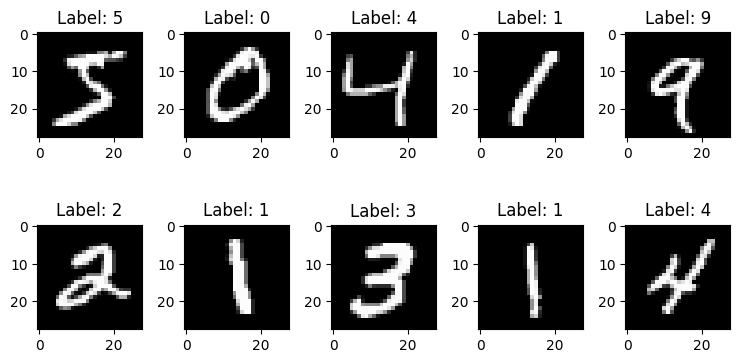

In [8]:
num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i])) # per vedere i label scritti sopra (Targets)
plt.tight_layout()
plt.show()

guardando le immagini si vede che non c'è particolare simmetria nel problema, anzi, la differenza tra 6 e 9 sta tutta nell'orintazione. Quindi non ci sono i presupposti per fare DATA AUGMENTATION

In [9]:
# printing data shapes per vedere la dimensione delle immagini
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape) # saranno 32 label visto che fa batch da 32
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


### Defining the model

In `PyTorch`, we define a model by subclassing the `nn.Module` class and defining the `forward` method. The `forward` method is where we define the *computation* that happens at every *forward pass* of the model.

Except for extreme corner-cases, the backward pass is automatically defined by `PyTorch` *autograd* system and gradients are obtained efficiently whenever needed.

`PyTorch` modules are *transparent* with respect to batch sizes, i.e. we can use the same model to process a single sample or a batch of samples, without worrying about the exact batch size.

Per definire un modello in pytorch si crea una sottoclasse di nn.Module che è la classe di base su cui costruire l'architettura della NN.
In OGNI ARCHITETTURA bisogna definire:


*   Layers che si vuole
*   La funzione FORWARD: che è quella che fa la computazione del modello

MENTRE il BACKWARD PASS viene fatto automaticamente da Pytorch e non serve definirlo!!!!
Quando definisci l'architettura non serve che definisci il BATCH-SIZE, non gli serve saperlo!!



In [10]:
# definisco il mio modello
class MyModel(nn.Module):
  # creo l'inizializzatorre (costruttore)
    def __init__(self):

        # ereditiamo tutte le proprietà del modulo superiore
        super(MyModel, self).__init__()

        # posso anche dichiarare qui tutti i layer che si vuole utilizzare e poi richiamarli nella funzione forward
        # DEFINISCO un LAYER CONVOLUZIONALE 2D che prende come input#
        # in_channel: 1 boh?
        # out_channel: 32 "perchè mi piace 32"  Queste sono le dimensionalità del LAYER
        # scelgo una dimensione del kernel-size: 3 (o 5 di solito si sceglie dispari)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # LAYER LINEARE (out_chanel di sopra*26*26, 128 è la dimensionalità del layer sucessivo
        self.l1 = nn.Linear(32 * 26 * 26, 128)
        # altro LAYER LINEARE: input è l'output di quello prima, e 10 è OUTPUT (numeri da 0 a 9)
        self.l2 = nn.Linear(128, 10)


    def forward(self, x):
        # 1)chiamo prima la convoluzione che manda il BATCH-SIZEx1x28x28 in 32x26x26 (per trasformare l'immagine?)
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # 2) chiamo la RELU sull'output della convoluzione
        # Activation function
        x = F.relu(x)

        # 3) trasformo in un vettore da 32x26x26 = 21632
        # flatten => BS x (32*26*26) = BS x 21632
        x = x.flatten(start_dim = 1)

        # 4) chiamo il PRIMO LINEAR
        # BSx(32*26*26) => BSx128
        x = self.l1(x)

        # 5) applico di nuovo la RELU
        x = F.relu(x)

        # 6) applico il SECONDO LINEARE che mi da l'output
        # BSx128 => BSx10
        logits = self.l2(x)

        # 7) faccio il SOFTMAX finale per trasformare l'output in probabilità
        # Softmax computation
        out = F.softmax(logits, dim=1)
        
        return out

### Model instantiation and test with a single batch
We haven't trained the model yet, so it's not going to give us good results. However, we can still test it on a single batch of data to see if it works from the implementation viewpoint.

in questo caso facciamo girare il modello su un solo batch (32) per vedere se funziona: ci aspettiamo un output di 32x10 cioè 32 righe per 10 colonne

In [11]:
model = MyModel() # instanzio il modello
# images sono le x del trainLoader
out = model(images) # per fare la predizione passo il modello con l'input
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([32, 10])  i.e.: batch_size x num_classes


possiamo vedere anche l'accuratezza per un solo batch: bassissimo. (ha visto solo 32 immagini e nn c'ha capito molto)
Ma è giusto per vedeere che fuznioni!

In [12]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

print(f"Accuracy on the single batch just used: {get_batch_accuracy(out, labels)}%")

Accuracy on the single batch just used: 12.5%


MA noi possiamo utilizzarte la GPU che ci fa tanti bei calcoletti carini!!

Per utilizzare la CPU torch ha la funzione .device che inoltre mi controlla se ho cuda nel pc altrimenti usa la cPU

Quando instanzio il mio modello, devo MANDARLI alla GPU mandando `model = model.to(device)`! è importante!! altrimenti ti dice errore.

Per ora usiamo la CPU (non trova cuda quindi usa la cpu)

In [13]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Re-instantiate the model to reset the weights/gradients. 
# Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = MyModel()  
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cuda


PER ALLENARE FINALMENTE LA RETE definisco il NUM DI EPOCHE, LEARNING RATE, la LOSS e L'OPTIMIZER

In [14]:
# Number of times the whole (training) dataset is used for training
num_epochs = 5  # per far vedere cosa succede
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function che BEL!!
# uso modulo .optim per scegliere ADAM o altri ottimizzatori. Passo in input i parametri da ottimizzare e Learnig rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

Using `CPU`, this training loop is very slow. We can run it on [GPU](https://cloud.google.com/gpu) and make it very quick even on Colab by going to `Runtime` > `Change runtime type` and selecting `GPU` from the `Hardware accelerator` drop-down.

DEVO DEFINRE MANUALMENTE il TRAINING LOOP (parte noiosa di pytorch ma che poi viene ricompensata perchè è molto piu controllabile) 

In [15]:
for epoch in range(num_epochs):
    # inizializzo a zero la loss e la accuracy
    train_running_loss = 0.0
    train_acc = 0.0

    # 1) devo mettere il modello in trainig mode con .train() altrimenti non crea modello
    # Set the model to training mode: relevant for dropout, batchnorm, etc.
    model = model.train()
    # mettiamo il tempo per sfizio
    start = time()

    ## 2) training step : facciamo loopare sul TrainLOADER
    for i, (images, labels) in enumerate(trainloader):
        
        # mandiamo x e y a CUDA
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images) # queste sono le mie predizioni del mio modello
        loss = criterion(logits, labels) # calcolo la loss con criterio che ho scelto conforntanto la predizione con le label vere

        # Reset the gradients to zero: otherwise they accumulate! DEVO FARLO
        optimizer.zero_grad()

        # Backpropagation sulla loss EASY
        loss.backward()

        ## update model params FACCIO update dei parametri del modello
        optimizer.step()

        # aggiungiamo la loss alla somma di loss che ho avuto finora
        train_running_loss += loss.item()
        # e prendiamo la accuracy da aggiungere
        train_acc += get_batch_accuracy(logits, labels)
    

    # per testare il loop devo usare eval.() e per uscire dallo stato di training
    model.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")        

Epoch: 1 | Loss: 1.6694 | Train Accuracy: 79.4240 | Time: 19.13
Epoch: 2 | Loss: 1.4937 | Train Accuracy: 97.0901 | Time: 14.66
Epoch: 3 | Loss: 1.4819 | Train Accuracy: 98.1890 | Time: 18.33
Epoch: 4 | Loss: 1.4771 | Train Accuracy: 98.6243 | Time: 15.83
Epoch: 5 | Loss: 1.4742 | Train Accuracy: 98.8894 | Time: 14.82


Without GPU: ~160s/epoch   
With GPU: ~13s/epoch   


con solo 5 epoche gia va al 90% di accuratezza

### Test loop

PER TESTARE IL MODELLO:

In [16]:
# setto a zero la test_acc
test_acc = 0.0

for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device) # x al device
    labels = labels.to(device) # y al device
    outputs = model(images) # predizioni
    test_acc += get_batch_accuracy(outputs, labels) # accuratezza
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 98.4776
